# 什么是内核记忆（Kernel Memory）

Kernel Memory，内核记忆（KM）是一种多模态人工智能服务，旨在为应用程序提供长期记忆解决方案，模仿人类存储信息的记忆能力。专门通过自定义连续数据混合管道对数据集进行高效索引，并支持检索增强生成（RAG）。
KM 可以作为一个Web服务独立部署，也可以作为一个插件集成到ChatGPT/Copilot/Semantic Kernel 中，也可以作为一个.NET 库集成到应用中。
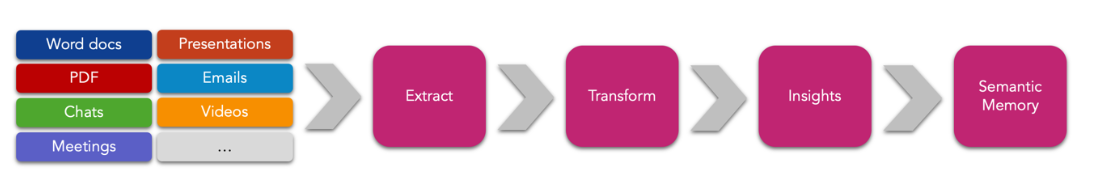

通过利用先进的嵌入和大型语言模型，KM 支持自然语言查询，以便从索引数据中获取答案，并返回带有引用和指向原始来源的链接。

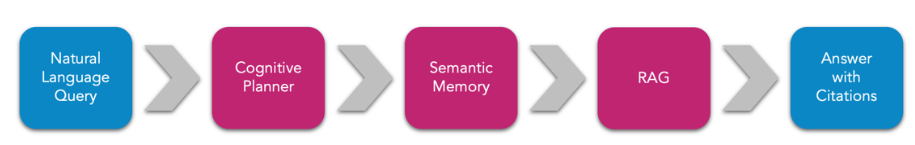

# Kernal Memory vs Semantic Memory

内核记忆（KM）是一项基于开发语义内核（SK）和语义记忆（SM）过程中所收到的反馈和汲取的经验教训而构建的服务。它提供了一些原本需要手动开发的功能，例如存储文件、从文件中提取文本、提供保护用户数据的框架等。KM 的代码库完全使用.NET 编写，这消除了用多种语言编写和维护功能的需求。作为一项服务，KM 可以在任何语言、工具或平台上使用，例如浏览器扩展和 ChatGPT 助手。

语义记忆（Semantic Memory，SM）是适用于 C#、Python 和 Java 的库，它包装了对数据库的直接调用并支持向量搜索。它是作为语义内核（Semantic Kernel，SK）项目的一部分开发的，并且是长期记忆的首次公开迭代。核心库以三种语言进行维护，而受支持的存储引擎列表（称为“连接器”）因语言而异。

| 特性 | Kernel Memory | Semantic Memory |
| :--: | :--: | :--: |
| 数据格式 | Web页面、PDF、图像、Word、PowerPoint、Excel、Markdown、文本、JSON、HTML | 仅文本 |
| 搜索 | 余弦相似度、带过滤器的混合搜索（AND/OR条件） | 余弦相似度 |
| 语言支持 | 任何语言，命令行工具，浏览器扩展，低代码/无代码应用，聊天机器人，助手等 | C#、Python、Java |
| 存储引擎 | Azure AI Search、Elasticsearch、MongoDB Atlas、Postgres+pgvector、Qdrant、Redis、SQL Server、内存KNN、磁盘KNN | Azure AI Search、Chroma、DuckDB、Kusto、Milvus、MongoDB、Pinecone、Postgres、Qdrant、Redis、SQLite、Weaviate |
| 文件存储 | Disk、Azure Blob、AWS S3、MongoDB Atlas、内存（易失性） | - |
| RAG | 是 | - |
| 摘要 | 是 | - |
| OCR | 是，通过Azure Document Intelligence | - |
| 安全过滤器 | 是 | - |
| 大型文档摄取 | 是，包括使用队列的异步处理（Azure Queues、RabbitMQ、基于文件的或内存队列） | - |
| 文档存储 | 是 | - |
| 自定义存储架构 | 一些DBs | - |
| 带内部嵌入的向量DBs | 是 | - |
| 同时写入多个向量DBs | 是 | - |
| LLMs | Azure OpenAI、OpenAI、Anthropic、Ollama、LLamaSharp、LM Studio、Semantic Kernel Connectors | Azure OpenAI、OpenAI、Gemini、Hugging Face、ONNX、自定义等 |
| 带专用分词器的LLMs | 是 | 否 |
| 云部署 | 是 | - |
| 带OpenAPI的Web服务 | 是 | - |

# 核心概念

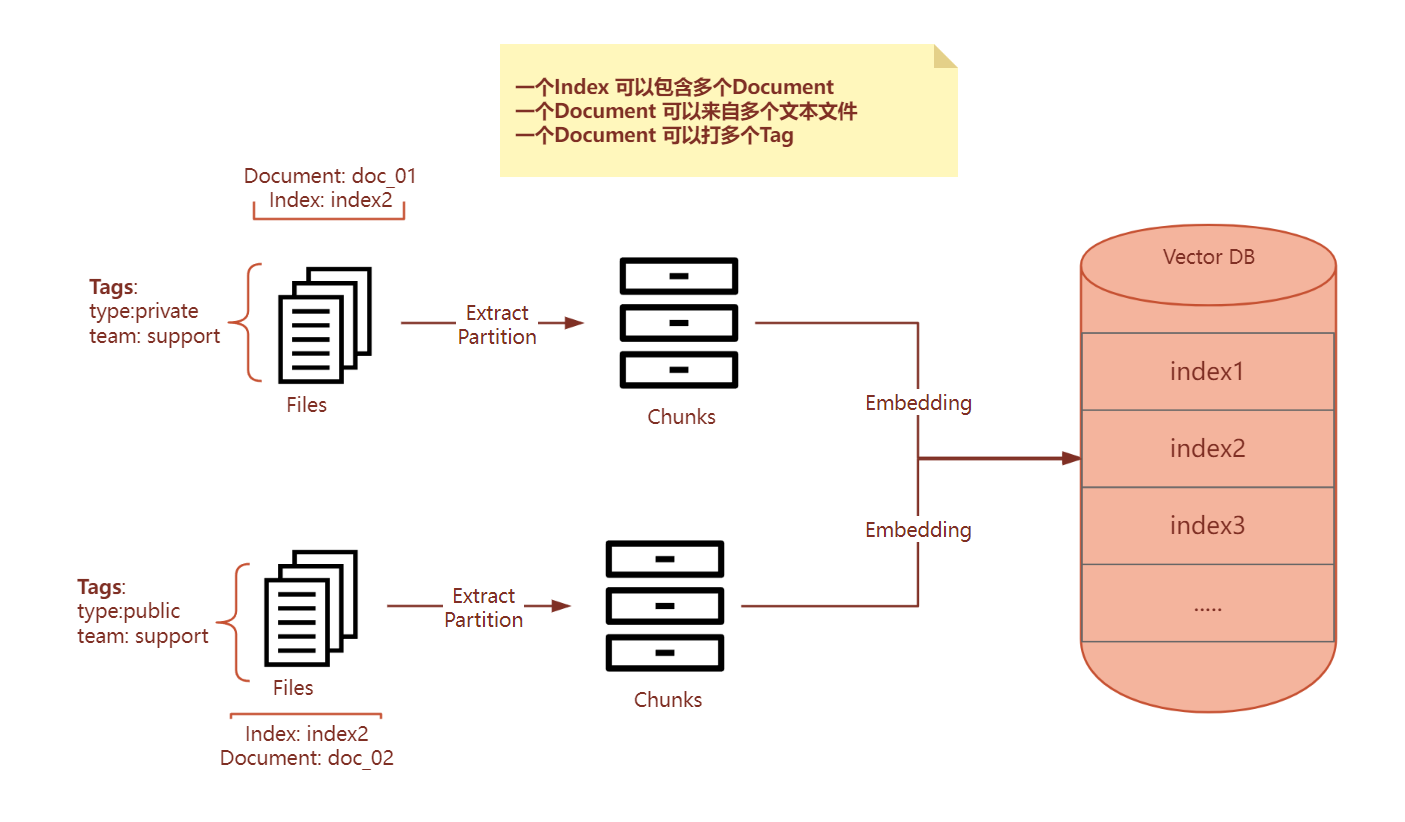

## Document
文档，将信息(一个或多个文件，照片，或一段文本）上传到KM时，这些数据被打包为一个文档，并拥有唯一ID，通过这个ID 可以更新、替换或删除该文档的数据。以下示例中一次导入多个不同类型的文件，但它们被命名为`doc001` Document。
```
var memory = new KernelMemoryBuilder()
    .WithOpenAIDefaults(env["OPENAI_API_KEY"])
    .Build<MemoryServerless>();

await memory.ImportDocumentAsync(new Document("doc001")
            .AddFiles(["file1.txt", "file2.docx", "file3.pdf"]);
```
如果再次以相同Document ID 导入新文档，则之前导入的文档会被覆盖。

## Tag
标签，是一个键值对，通过给Document 打标签，以便在搜索时，通过指定标签限定搜索文档范围。以下示例中可以看出一个Document 可以有多个Tag，一个Tag 可以有多个值。

```
var memory = new KernelMemoryBuilder()
    .WithOpenAIDefaults(env["OPENAI_API_KEY"])
    .Build<MemoryServerless>();
    
await memory.ImportDocumentAsync(new Document("doc001")
            .AddFiles(["file1.txt", "file2.docx", "file3.pdf"])
            .AddTag("user", "Taylor")
            .AddTag("collection", "meetings")
            .AddTag("collection", "NASA")
            .AddTag("collection", "space")
            .AddTag("type", "news"));
```

## Index
索引，KM 利用向量存储来保存摄入的文档信息，像 Azure AI Search、Qdrant、Elastic Search、Redis 等解决方案。
为了对不同的数据加以区分，通过指定不同的索引名称来实现，索引之间的数据是隔离的。在存储信息、搜索和提问时，KM始终在一个索引的范围内工作。
换句话说，可以将多个Document 存储在单个索引下。
```
var memory = new KernelMemoryBuilder()
    .WithOpenAIDefaults(env["OPENAI_API_KEY"])
    .Build<MemoryServerless>();
    
await memory.ImportDocumentAsync(
     document: new Document("doc001").AddFiles(["file1.txt", "file2.docx", "file3.pdf"]),
     index:"index1");
await memory.ImportDocumentAsync(
     document: new Document("doc002").AddFiles(["file4.txt", "file5.docx"]),
     index:"index1");
```
当未指定`index`时，将存储在名为`default`的索引下。同理，`AskAsync`和`SerachAsync`在未指定`index`时，默认在`default`索引下进行检索。
```
// 在index1索引下检索
var result = await  memory.AskAsync("What is Kernel Memory?", index: "index1");
// 在default索引下检索
var result2 = await  memory.SearchAsync("What is Kernel Memory?");
```

## Chunk

对读取的文档数据进行处理，将大块数据分解为更小、更易于处理的单元的过程，称为**chunking**，分解得到的单元称为**chunk**。

通过分块，可以将文本拆分为单词、句子、段落还是整个文档，分块级别决定了检索到的信息的颗粒度。

举例而言：假设您在法律研究应用程序中使用RAG模型，并且您需要从大型法律文档中检索相关部分。用户询问，“法律对医疗保健中的数据隐私有什么规定？”。
如果系统采用**文档级分块**，它将检索整个法律文档，这可能是压倒性和低效的。然而，通过使用**段落级分块**，系统能检索专门讨论医疗保健数据隐私法的段落，给用户一个高度相关和简洁的答案。

如果没有分块，系统可能会检索文档中不相关的部分，从而提供糟糕的用户体验。通过分块，检索变得有针对性和有意义，增强了模型生成准确和上下文感知响应的能力。

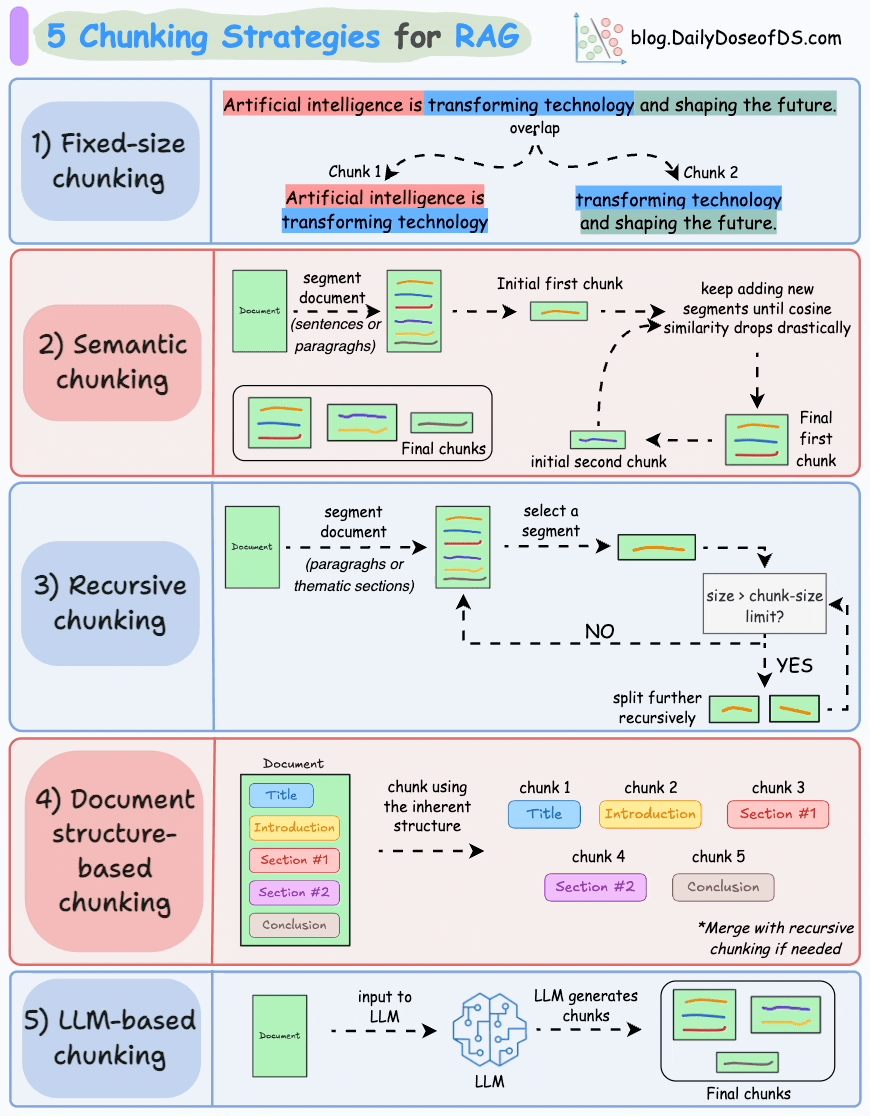


